# EXPLORATORY DATA ANALYSIS ON AIR POLLUTION

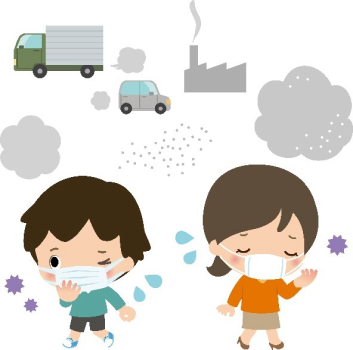

# REQUIRED_lIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


# User defined Functions

In [2]:
def stationary_check(df):
    for i in df.columns:
        decomposition = seasonal_decompose(df[i], model="additive")

# remove the seasonal component from the time series data
        seasonal_com = decomposition.seasonal
        seasonal_removed = df[i]- seasonal_com    
    # detrend the time series data using first-order differencing
        detrended = seasonal_removed.dropna()

# remove the trend component from the time series data
        trend_component = detrended.cumsum()
        detrended_seasonal_removed =seasonal_removed - trend_component
     #Perform Dickey-Fuller test:
        test = adfuller(detrended_seasonal_removed, autolag='AIC')
        output = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            output['Critical Value (%s)'%key] = value    
            if output[1] <= 0.05:
                print('The variable', i )
                print("Reject the null hypothesis")
                print("Data has no unit root and is stationary")
                break
                
def plot_ecdf(data, title = 'ECDF PLOT', xlabel = 'DataValues', ylabel = 'Percentage'):
    x_axis = np.sort(data)
    y_axis = np.arange(1, len(data)+1)/len(data)
    plt.plot(x_axis, y_axis, linestyle = 'dashed', marker = '.')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(ylabel)
    plt.margins(0.04)
    
    
def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')
    
    if dfoutput[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
        
def rolling_window(data):
#eterming rolling statistics
    roll_mean = data.rolling(window=4).mean()
    roll_std = data.rolling(window=4).std()

    mean = plt.plot(roll_mean, color='pink', label='Rolling Mean')
    std = plt.plot(roll_std, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    return roll_mean
        

def resampling_tech(data):
    decomposition = seasonal_decompose(df[data], model="additive")

# remove the seasonal component from the time series data
    seasonal_com = decomposition.seasonal
    seasonal_removed = df[data] - seasonal_com

# plot the original time series data, seasonal component, and seasonality-removed data
    plot = decomposition.plot()
    
    # detrend the time series data using first-order differencing
    detrended = seasonal_removed.dropna()

# remove the trend component from the time series data
    trend_component = detrended.cumsum()
    detrended_seasonal_removed =seasonal_removed - trend_component
    final_plot = detrended_seasonal_removed.plot()
    return detrended_seasonal_removed 

# LOAD THE DATA

In [3]:
df_sam = pd.read_csv('LSTM-Multivariate_pollution.csv',parse_dates=True,squeeze=True,index_col=0)
df_sam.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [4]:
# USING AS.TYPE WE CAN CONVERT DATATYPE
df_sam['pollution'] = df_sam['pollution'].astype('int')
df_sam['temp'] = df_sam['temp'].astype('int')
df_sam['press'] = df_sam['press'].astype('int')
df_sam['wnd_spd'] = df_sam['wnd_spd'].astype('int')

In [5]:
df_sam['wnd_dir'].unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [6]:
from sklearn.preprocessing import LabelEncoder
# Initialize the label encoder
le = LabelEncoder()

# Fit and transform the data
df_sam['wnd_dir'] = le.fit_transform(df_sam['wnd_dir'])

In [7]:
# take the copy of the original dataset to check stationarity
df_stationary = df_sam.copy()

# Missing Values check

In [8]:
df_sam.isnull().sum()

pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

``Interpretation``


                1. The dataset is clean so it has no missing values.

# ADD a Column that indicates the pollution level 

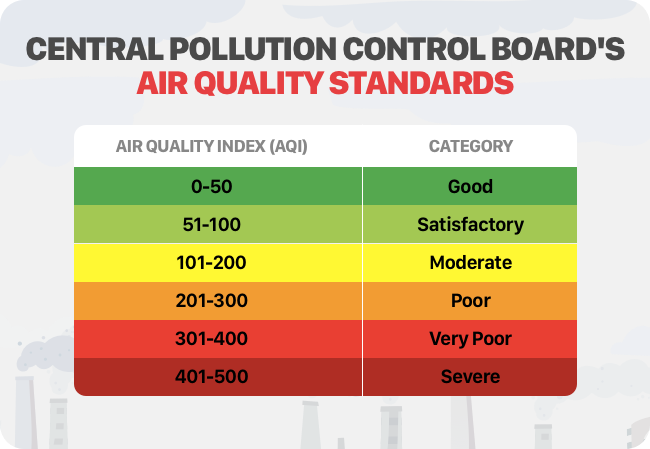

In [9]:
indicators = {
    'good': df_sam['pollution'].between(0, 51),
    'satisfactory': df_sam['pollution'].between(51, 101),
    'moderate': df_sam['pollution'].between(101, 201),
    'poor': df_sam['pollution'].between(201, 301),
    'very_poor': df_sam['pollution'].between(301, 401),
    'severe': df_sam['pollution'].between(401, 501),
    'danger': df_sam['pollution'].values > 501
}
df_sam['pollu_indicators'] = np.select(indicators.values(), indicators.keys())

# This will helps us to understand the pollution level of the air.

In [10]:
# Check if date has been defined as an index
df_sam.index

DatetimeIndex(['2010-01-02 00:00:00', '2010-01-02 01:00:00',
               '2010-01-02 02:00:00', '2010-01-02 03:00:00',
               '2010-01-02 04:00:00', '2010-01-02 05:00:00',
               '2010-01-02 06:00:00', '2010-01-02 07:00:00',
               '2010-01-02 08:00:00', '2010-01-02 09:00:00',
               ...
               '2014-12-31 14:00:00', '2014-12-31 15:00:00',
               '2014-12-31 16:00:00', '2014-12-31 17:00:00',
               '2014-12-31 18:00:00', '2014-12-31 19:00:00',
               '2014-12-31 20:00:00', '2014-12-31 21:00:00',
               '2014-12-31 22:00:00', '2014-12-31 23:00:00'],
              dtype='datetime64[ns]', name='date', length=43800, freq=None)

In [11]:
# To show the number of records and columns in a dataframe 
print("The number of rows: ",df_sam.shape[0], "\n""The number of columns: ",df_sam.shape[1])

The number of rows:  43800 
The number of columns:  9


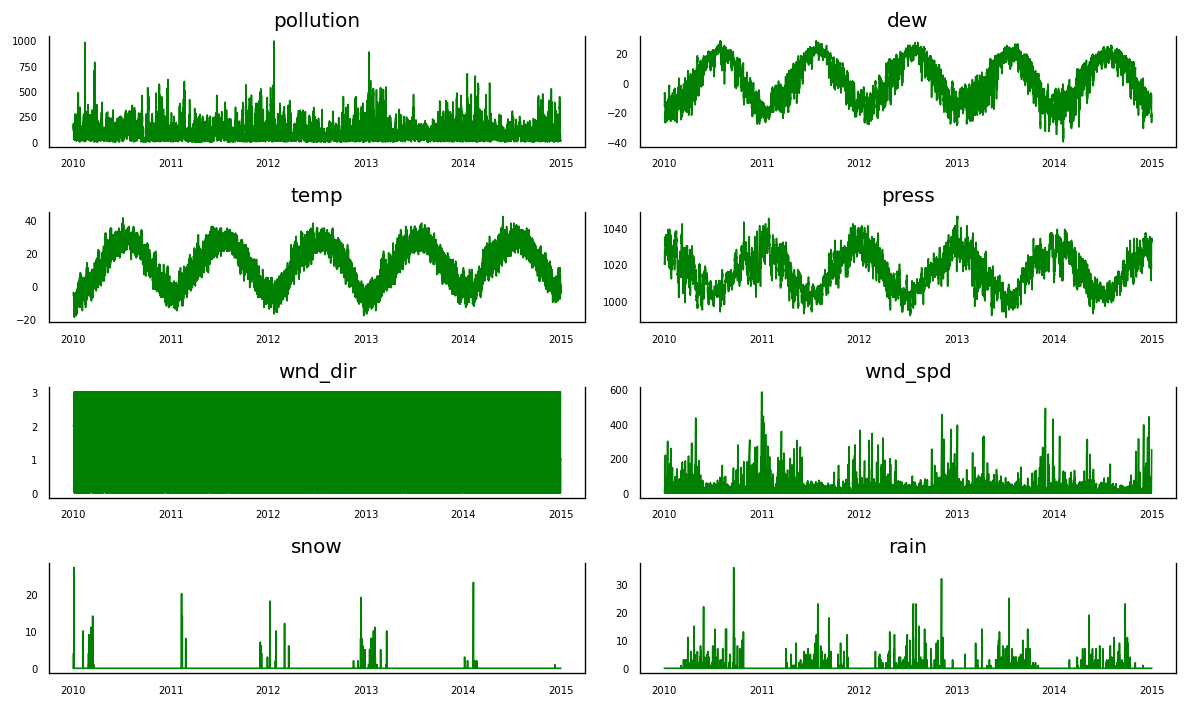

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_sam[df_sam.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(df_sam.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Extract some additional features to get more information 

In [13]:
#Let us extract some additional features
#Creating separate columns for 'Year','Month','Day' and 'WeekofYear'
df_sam['Year'] = df_sam.index.year
df_sam['Month'] = df_sam.index.month
df_sam['Day'] = df_sam.index.day
df_sam['WeekOfYear'] = df_sam.index.weekofyear
df_sam['Hours'] = df_sam.index.hour

df_sam.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollu_indicators,Year,Month,Day,WeekOfYear,Hours
date,,,,,,,,,,,,,,
2010-01-02 00:00:00,129,-16,-4,1020,2,1,0,0,moderate,2010,1,2,53,0
2010-01-02 01:00:00,148,-15,-4,1020,2,2,0,0,moderate,2010,1,2,53,1
2010-01-02 02:00:00,159,-11,-5,1021,2,3,0,0,moderate,2010,1,2,53,2
2010-01-02 03:00:00,181,-7,-5,1022,2,5,1,0,moderate,2010,1,2,53,3
2010-01-02 04:00:00,138,-7,-5,1022,2,6,2,0,moderate,2010,1,2,53,4


In [14]:
# LEt us see how many years are there in a data
df_sam.Year.unique()

array([2010, 2011, 2012, 2013, 2014], dtype=int64)

# Yearly pollution level 

In [15]:
# lets make the average pollution level based on the year
#average_pollution_by_year = df.groupby(pd.Grouper(key='year', freq='Y'))['pollution_level'].mean()

yearly_avg_pollu= df_sam.groupby(['Year', 'pollu_indicators'])['pollution'].max()
yearly_avg_pollu

Year  pollu_indicators
2010  danger              980
      good                 51
      moderate            201
      poor                301
      satisfactory        101
      severe              501
      very_poor           400
2011  danger              595
      good                 51
      moderate            201
      poor                301
      satisfactory        101
      severe              499
      very_poor           401
2012  danger              994
      good                 51
      moderate            201
      poor                301
      satisfactory        101
      severe              501
      very_poor           401
2013  danger              886
      good                 51
      moderate            201
      poor                301
      satisfactory        101
      severe              498
      very_poor           401
2014  danger              671
      good                 51
      moderate            201
      poor                301
      satisfactor

``Interpretation``

    1. As per the Central pollution Control Board our data has a value above satisfactory level.
    
    2. In  ``2012`` is the most polluted year among all. Here central board level of high is only upto 500 but here above the estimation so considered this as a most polluted year.

In [16]:
df = pd.merge(df_sam, yearly_avg_pollu, on='Year', how='left')
df = df.rename(columns={'pollution_y': 'avg_pollu_year', 'pollution_x': 'pollution'})

In [17]:
df.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow',
       'rain', 'pollu_indicators', 'Year', 'Month', 'Day', 'WeekOfYear',
       'Hours', 'avg_pollu_year'],
      dtype='object')

<AxesSubplot:xlabel='Year', ylabel='avg_pollu_year'>

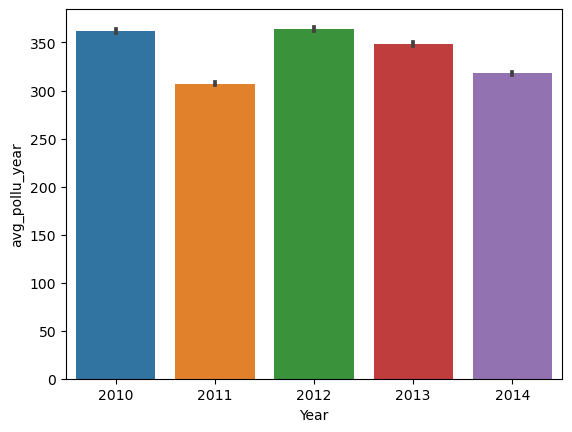

In [18]:
sns.barplot(y= df['avg_pollu_year'], x = df['Year'])

``Interpretation``

                1. This graph proves the context that we taken from the groupby function. This also shows the year ``2012`` is maximum 
    among all the years.
    
               2. The next maximum pollution level year is ``2010``.

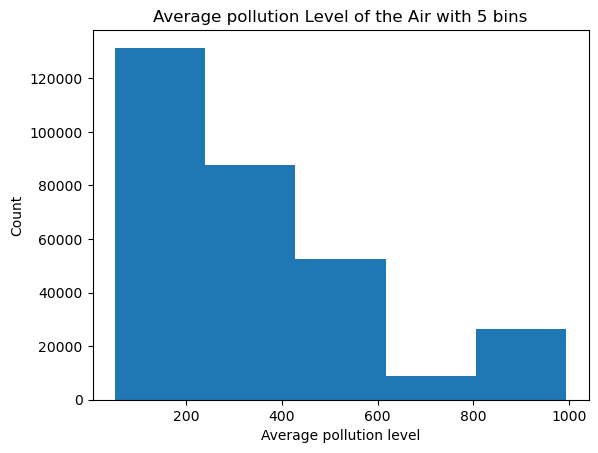

In [19]:
# Looking the average pollution level of the air using bins
plt.hist(df['avg_pollu_year'], bins = 5)
plt.title('Average pollution Level of the Air with 5 bins')
plt.xlabel('Average pollution level')
plt.ylabel('Count')
plt.show()

# Monthly pollution level

In [20]:
# Average pollution level baed on month
monthly_avg_pollu = df_sam[df_sam['pollu_indicators'] == 'danger'].groupby('Month')['pollution'].max()
monthly_avg_pollu

Month
1     994
2     980
3     784
4     580
10    562
11    569
12    615
Name: pollution, dtype: int32

``Interpretation``

             1. Among the months only the following months are having  danger level.
    
             2. Among them january month had a lot. In this month many important days including new year celebration for world wide
         and republic day celebration for India level and ``Pongal`` festival for State level.
            
             3. When we see the month first 4 and last 3 only had more pollution level. Let us consider ``December``month we are celebrating 
                ``Christmas`` which was celebrated by worldwide.

In [21]:
df = pd.merge(df_sam, monthly_avg_pollu, on='Month', how='left')
df = df.rename(columns={'pollution_y': 'avg_pollu_mon', 'pollution_x': 'pollution'})

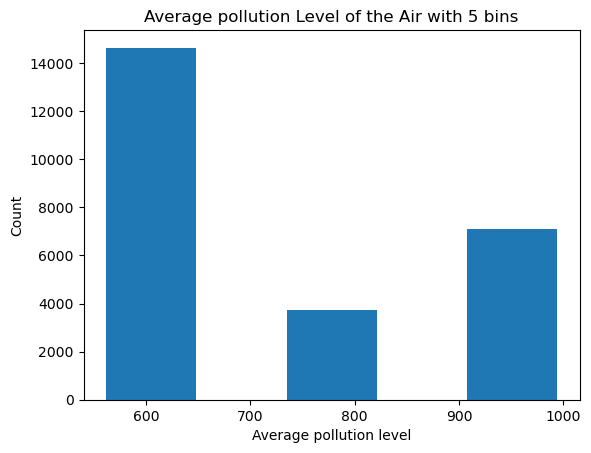

In [22]:
# Looking the average pollution level of the air using bins
plt.hist(df['avg_pollu_mon'], bins = 5)
plt.title('Average pollution Level of the Air with 5 bins')
plt.xlabel('Average pollution level')
plt.ylabel('Count')
plt.show()

<AxesSubplot:xlabel='Month', ylabel='pollution'>

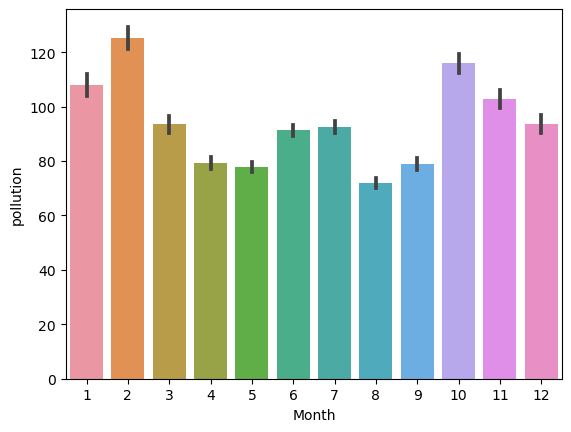

In [23]:
sns.barplot(y= df['pollution'], x = df['Month'])

<AxesSubplot:xlabel='Month', ylabel='avg_pollu_mon'>

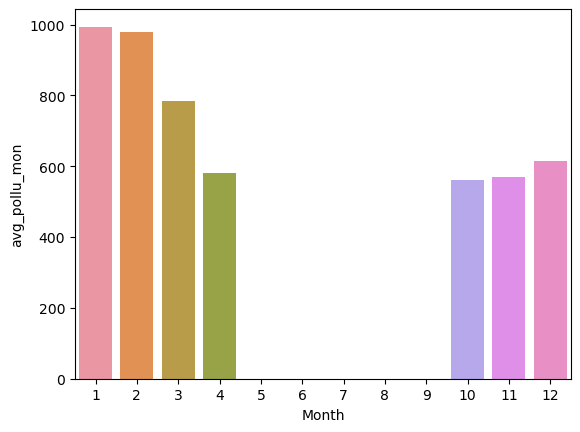

In [24]:
sns.barplot(y= df['avg_pollu_mon'], x = df['Month'])

# Weekly pollution level

In [25]:
# Average pollution level baed on month
df_sam.groupby('WeekOfYear')['pollution'].max().sort_values(ascending = False)

WeekOfYear
4     994
6     980
2     886
12    784
11    700
3     671
7     649
51    615
8     595
15    580
9     577
46    569
40    562
50    528
5     526
48    522
10    516
44    481
49    480
43    472
26    466
13    465
25    459
52    457
37    455
41    454
47    445
42    430
1     413
29    390
16    389
39    386
32    360
35    341
33    337
19    320
38    316
21    314
30    313
18    312
28    310
17    307
45    304
27    303
20    298
36    287
24    285
14    279
22    261
31    250
23    241
34    211
53    181
Name: pollution, dtype: int32

``Interpretation``

            1. This gives the week wise maximum pollution level among the years given.
            
            2. Among them 4th week has the most level of pollution.

In [26]:
weekly_avg_pollu = df_sam[df_sam['pollu_indicators'] == 'danger'].groupby('WeekOfYear')['pollution'].max().sort_values(ascending = False)
weekly_avg_pollu

WeekOfYear
4     994
6     980
2     886
12    784
11    700
3     671
7     649
51    615
8     595
15    580
9     577
46    569
40    562
50    528
5     526
48    522
10    516
Name: pollution, dtype: int32

``Interpretation``

              1. These are the weeks that we have to keep in mind for further process. Because these are the weeks causes very high 
    seasonality. 

In [27]:
df = pd.merge(df_sam, weekly_avg_pollu, on='WeekOfYear', how='left')
df = df.rename(columns={'pollution_y': 'avg_pollu_week', 'pollution_x': 'pollution'})

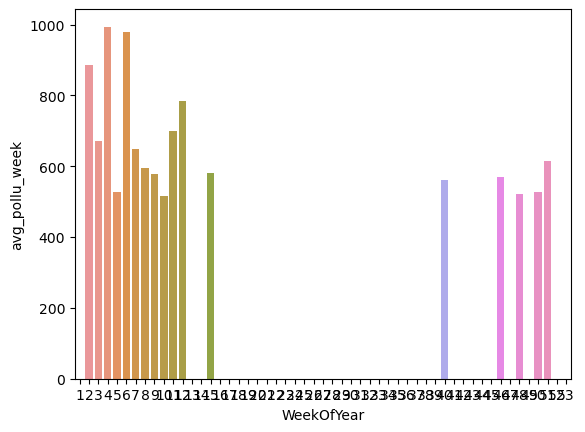

In [28]:
sns.barplot(y= df['avg_pollu_week'], x = df['WeekOfYear'])
plt.show()

# Day level pollution on Air

In [29]:
# Average pollution level baed on month
df_sam.groupby('Day')['pollution'].max().sort_values(ascending = False)

Day
23    994
14    980
12    886
22    784
13    744
20    700
16    671
15    649
21    615
18    603
9     580
25    577
19    569
26    562
17    541
6     534
10    534
24    532
29    526
28    525
4     522
7     516
2     494
3     477
27    470
8     470
31    469
30    460
11    456
5     416
1     347
Name: pollution, dtype: int32

In [30]:
daily_avg_pollu = df_sam[df_sam['pollu_indicators'] == 'danger'].groupby(['Day', 'Year','Month'])['pollution'].max().sort_values(ascending = False)
daily_avg_pollu

Day  Year  Month
23   2012  1        994
14   2010  2        980
12   2013  1        886
22   2010  3        784
13   2013  1        744
20   2010  3        700
16   2014  1        671
15   2014  2        649
21   2010  12       615
18   2013  1        603
21   2011  2        595
9    2014  4        580
25   2014  2        577
22   2010  12       573
19   2010  11       569
15   2014  1        567
9    2011  10       562
26   2014  2        562
19   2012  1        558
17   2013  3        541
10   2012  1        534
6    2010  10       534
24   2013  2        532
19   2010  12       528
29   2013  1        526
20   2011  2        526
17   2010  11       525
28   2013  2        525
14   2013  1        523
26   2014  11       522
4    2011  12       522
18   2010  11       521
     2013  3        517
7    2013  3        516
9    2013  2        512
28   2013  1        510
7    2010  10       505
Name: pollution, dtype: int32

``Interpretation``

                  1. From this groupby In the year ``2012`` ``January`` month 23 rd is a Monday. 
    
                  2. Monday all of them returning school, offices, etc.. So in terms of days Monday had most  pollution level.
        
                  3. The second highest level of pollution in the year ``2010`` ''Febrary`` month 14th is the 2nd highest that is ``Valentinesday`` which was celebrated by whole world.
            
                  4. The Third highest level of pollution in the year ``2013`` `` January`` month 12th that is ``saturday``.


In [31]:
df_sam.Year.unique()

array([2010, 2011, 2012, 2013, 2014], dtype=int64)

In [32]:
df = pd.merge(df_sam, daily_avg_pollu, on='Day', how='left')
df = df.rename(columns={'pollution_y': 'daily_avg_pollu', 'pollution_x': 'pollution'})

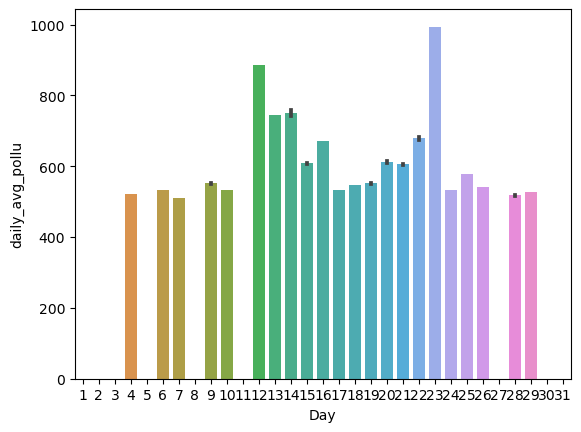

In [33]:
sns.barplot(y= df['daily_avg_pollu'], x = df['Day'])
plt.show()

# HOURLY BASIS POLLUTION LEVEL

In [34]:
df_sam.groupby(['Hours', 'pollu_indicators'])['pollution'].max().sort_values(ascending = False).head(10)

Hours  pollu_indicators
1      danger              994
2      danger              972
20     danger              886
22     danger              858
21     danger              852
16     danger              845
19     danger              824
17     danger              810
23     danger              805
15     danger              802
Name: pollution, dtype: int32

``Interpretation``


                  1. 1st 2 highest pollution in the hours between 2 and 3, because time index starts from end of every hour. As per the Indian Standard Time Night timings,
    most of the load trucks, lorries, travel agencies are roaming that time.
    
                  2. Next highest pollution level in the hour night 7 to 12 are maximum polluted. Most of them returned from office,schools , etc. Most of the peak timings have more pollution level.

In [35]:
hourly_avg_pollu = df_sam[df_sam['pollu_indicators'] == 'danger'].groupby(['Hours'])['pollution'].max().sort_values(ascending = False)
hourly_avg_pollu

Hours
1     994
2     972
20    886
22    858
21    852
16    845
19    824
17    810
23    805
15    802
10    784
18    776
11    761
0     744
4     700
3     684
5     673
6     618
13    562
12    551
14    542
7     532
9     526
8     519
Name: pollution, dtype: int32

In [36]:
import matplotlib

In [37]:
matplotlib.__version__

'3.5.2'

In [38]:
df = pd.merge(df_sam, hourly_avg_pollu, on='Hours', how='left')
df = df.rename(columns={'pollution_y': 'hourly_avg_pollu', 'pollution_x': 'pollution'})

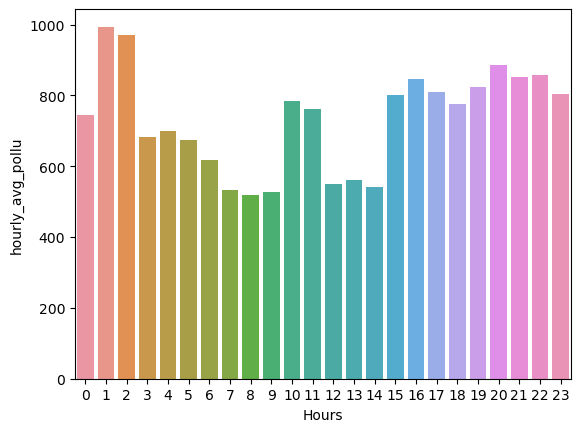

In [39]:
sns.barplot(y= df['hourly_avg_pollu'], x = df['Hours'])
plt.show()

# EMPRICAL CUMMULATIVE DISTRIBUTIVE FUNCTION

In [40]:
def plot_ecdf(data, title = 'ECDF PLOT', xlabel = 'DataValues', ylabel = 'Percentage'):
    x_axis = np.sort(data)
    y_axis = np.arange(1, len(data)+1)/len(data)
    plt.plot(x_axis, y_axis, linestyle = 'dashed', marker = '.')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(ylabel)
    plt.margins(0.04)

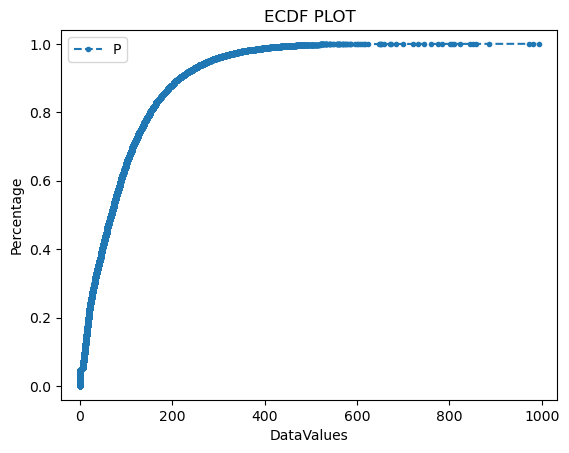

In [41]:
plot_ecdf(df['pollution'])

In [42]:
df.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow',
       'rain', 'pollu_indicators', 'Year', 'Month', 'Day', 'WeekOfYear',
       'Hours', 'hourly_avg_pollu'],
      dtype='object')

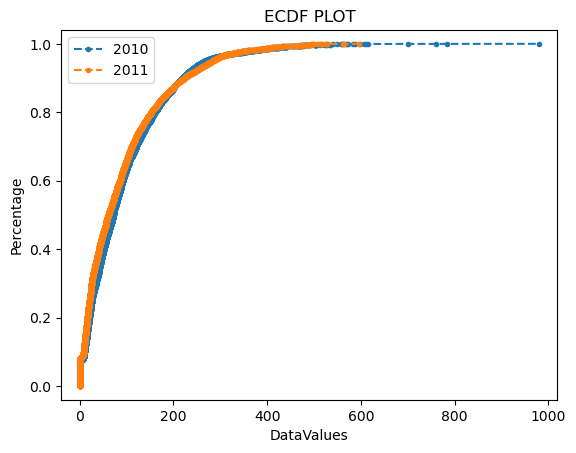

In [43]:
years = [2010,2011]

for i in years:
    plot_ecdf(df['pollution'][df['Year'] == i])
plt.legend(labels = years)
plt.show()


``Interpretation``

               1. By comparing the both the years 2010 has mximum pollution level across the years.

# OUTLIERS

In [44]:
df =df_sam.copy()

In [45]:
df

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollu_indicators,Year,Month,Day,WeekOfYear,Hours
date,,,,,,,,,,,,,,
2010-01-02 00:00:00,129,-16,-4,1020,2,1,0,0,moderate,2010,1,2,53,0
2010-01-02 01:00:00,148,-15,-4,1020,2,2,0,0,moderate,2010,1,2,53,1
2010-01-02 02:00:00,159,-11,-5,1021,2,3,0,0,moderate,2010,1,2,53,2
2010-01-02 03:00:00,181,-7,-5,1022,2,5,1,0,moderate,2010,1,2,53,3
2010-01-02 04:00:00,138,-7,-5,1022,2,6,2,0,moderate,2010,1,2,53,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8,-23,-2,1034,1,231,0,0,good,2014,12,31,1,19
2014-12-31 20:00:00,10,-22,-3,1034,1,237,0,0,good,2014,12,31,1,20
2014-12-31 21:00:00,10,-22,-3,1034,1,242,0,0,good,2014,12,31,1,21


<AxesSubplot:>

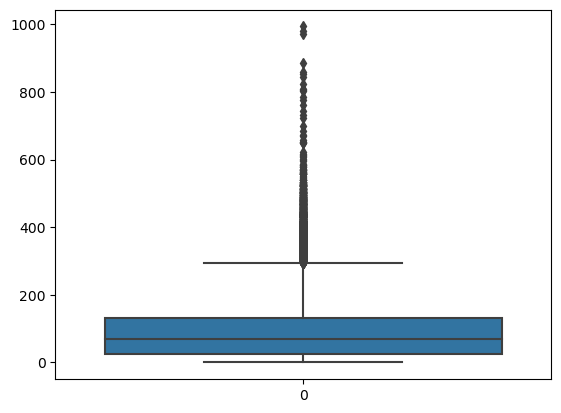

In [46]:
sns.boxplot(data = df['pollution'])

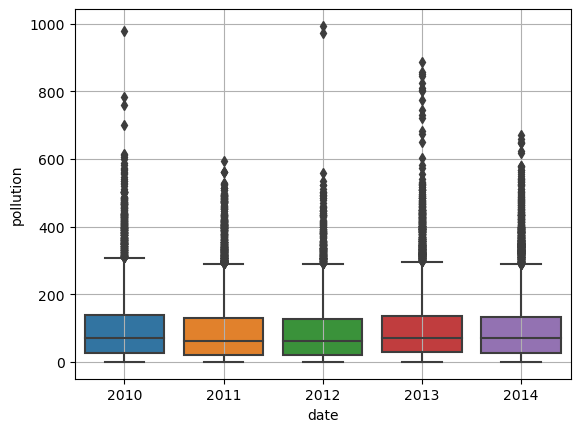

In [47]:
sns.boxplot(x = df.index.year,y = df['pollution'])
plt.grid();

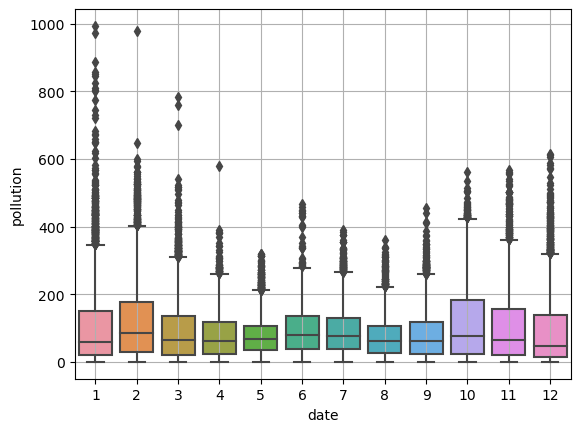

In [48]:
sns.boxplot(x = df.index.month,y = df['pollution'])
plt.grid();

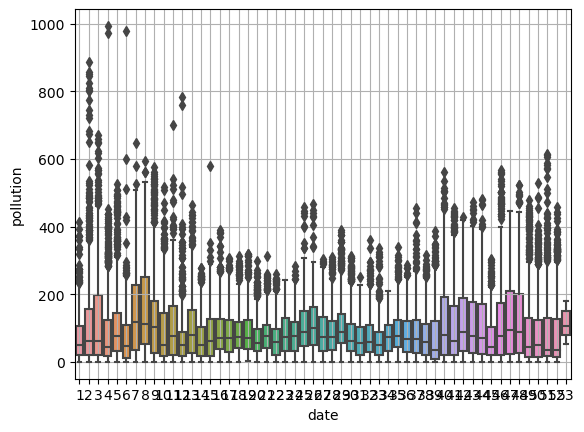

In [49]:
sns.boxplot(x = df.index.week,y = df['pollution'])
plt.grid();

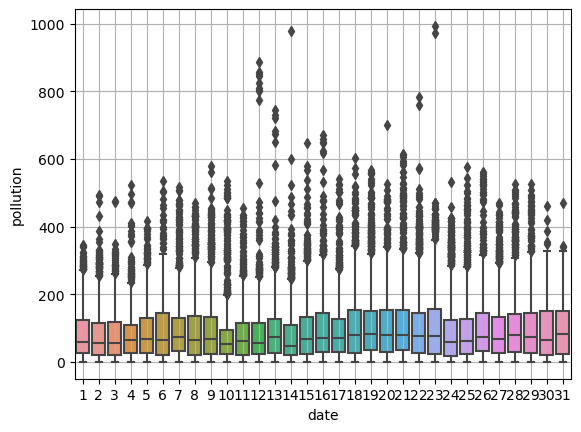

In [50]:
sns.boxplot(x = df.index.day,y = df['pollution'])
plt.grid();

# STATIONARY CHECK 

In [51]:
## Test for stationarity of the series - Dicky Fuller test

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')
    
    if dfoutput[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [52]:
test_stationarity(df_stationary['pollution'])

Results of Dickey-Fuller Test:
Test Statistic                   -21.004109
p-value                            0.000000
#Lags Used                        55.000000
Number of Observations Used    43744.000000
Critical Value (1%)               -3.430499
Critical Value (5%)               -2.861606
Critical Value (10%)              -2.566805
dtype: float64 

Reject the null hypothesis
Data has no unit root and is stationary


In [53]:
def check_variables(df):
    for i in df.columns:
        decomposition = seasonal_decompose(df[i], model="additive")

# remove the seasonal component from the time series data
        seasonal_com = decomposition.seasonal
        seasonal_removed = df[i]- seasonal_com    
    # detrend the time series data using first-order differencing
        detrended = seasonal_removed.dropna()

# remove the trend component from the time series data
        trend_component = detrended.cumsum()
        detrended_seasonal_removed =seasonal_removed - trend_component
     #Perform Dickey-Fuller test:
        test = adfuller(detrended_seasonal_removed, autolag='AIC')
        output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in test[4].items():
            output['Critical Value (%s)'%key] = value    
            if output[1] <= 0.05:
                print('The variable', i )
                print("Data has no unit root and is stationary")
                break

In [54]:
df = df_stationary.copy()

In [55]:
df

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129,-16,-4,1020,2,1,0,0
2010-01-02 01:00:00,148,-15,-4,1020,2,2,0,0
2010-01-02 02:00:00,159,-11,-5,1021,2,3,0,0
2010-01-02 03:00:00,181,-7,-5,1022,2,5,1,0
2010-01-02 04:00:00,138,-7,-5,1022,2,6,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8,-23,-2,1034,1,231,0,0
2014-12-31 20:00:00,10,-22,-3,1034,1,237,0,0
2014-12-31 21:00:00,10,-22,-3,1034,1,242,0,0


In [56]:
check_variables(df)

In [57]:
test_stationarity(df_stationary['dew'])

Results of Dickey-Fuller Test:
Test Statistic                -6.122923e+00
p-value                        8.767004e-08
#Lags Used                     5.500000e+01
Number of Observations Used    4.374400e+04
Critical Value (1%)           -3.430499e+00
Critical Value (5%)           -2.861606e+00
Critical Value (10%)          -2.566805e+00
dtype: float64 

Reject the null hypothesis
Data has no unit root and is stationary


In [58]:
test_stationarity(df_stationary['temp'])

Results of Dickey-Fuller Test:
Test Statistic                    -3.938332
p-value                            0.001770
#Lags Used                        49.000000
Number of Observations Used    43750.000000
Critical Value (1%)               -3.430499
Critical Value (5%)               -2.861606
Critical Value (10%)              -2.566805
dtype: float64 

Reject the null hypothesis
Data has no unit root and is stationary


In [59]:
test_stationarity(df_stationary['press'])

Results of Dickey-Fuller Test:
Test Statistic                -7.391926e+00
p-value                        7.959145e-11
#Lags Used                     5.500000e+01
Number of Observations Used    4.374400e+04
Critical Value (1%)           -3.430499e+00
Critical Value (5%)           -2.861606e+00
Critical Value (10%)          -2.566805e+00
dtype: float64 

Reject the null hypothesis
Data has no unit root and is stationary


In [60]:
test_stationarity(df_stationary['wnd_dir'])

Results of Dickey-Fuller Test:
Test Statistic                   -23.991752
p-value                            0.000000
#Lags Used                        47.000000
Number of Observations Used    43752.000000
Critical Value (1%)               -3.430499
Critical Value (5%)               -2.861606
Critical Value (10%)              -2.566805
dtype: float64 

Reject the null hypothesis
Data has no unit root and is stationary


In [61]:
test_stationarity(df_stationary['wnd_spd'])

Results of Dickey-Fuller Test:
Test Statistic                   -33.919538
p-value                            0.000000
#Lags Used                         5.000000
Number of Observations Used    43794.000000
Critical Value (1%)               -3.430499
Critical Value (5%)               -2.861606
Critical Value (10%)              -2.566805
dtype: float64 

Reject the null hypothesis
Data has no unit root and is stationary


In [62]:
test_stationarity(df_stationary['snow'])

Results of Dickey-Fuller Test:
Test Statistic                   -27.343205
p-value                            0.000000
#Lags Used                        55.000000
Number of Observations Used    43744.000000
Critical Value (1%)               -3.430499
Critical Value (5%)               -2.861606
Critical Value (10%)              -2.566805
dtype: float64 

Reject the null hypothesis
Data has no unit root and is stationary


In [63]:
test_stationarity(df_stationary['rain'])

Results of Dickey-Fuller Test:
Test Statistic                   -33.760937
p-value                            0.000000
#Lags Used                        22.000000
Number of Observations Used    43777.000000
Critical Value (1%)               -3.430499
Critical Value (5%)               -2.861606
Critical Value (10%)              -2.566805
dtype: float64 

Reject the null hypothesis
Data has no unit root and is stationary


# We used to build a model with the following stationarity variable alone to make the better forecasting

# If the original dataset is not stationary we can follow the upcomings methods to make time series stationary

# Different Stationarity Methods:

# 1. Method for stationary differencing

In [64]:
df1 = df_sam.copy()

In [65]:
df1['pollu_diff_1'] = df1['pollution'] - df1['pollution'].shift(1)

In [66]:
df1['pollu_diff_1']=df1['pollu_diff_1'].dropna()

In [67]:
test_stationarity(df1['pollu_diff_1'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                   -36.858517
p-value                            0.000000
#Lags Used                        55.000000
Number of Observations Used    43743.000000
Critical Value (1%)               -3.430500
Critical Value (5%)               -2.861606
Critical Value (10%)              -2.566805
dtype: float64 

Reject the null hypothesis
Data has no unit root and is stationary


``Interpretation``

             1. Here I am trying to make the day wise data and make them stationary. 

# Method 2 Transformation

# 1. LogTransformation 

In [68]:
df1['pollution'].head()

date
2010-01-02 00:00:00    129
2010-01-02 01:00:00    148
2010-01-02 02:00:00    159
2010-01-02 03:00:00    181
2010-01-02 04:00:00    138
Name: pollution, dtype: int32

In [69]:
df1['pollu_log']= np.log(df1['pollution'])
df1.pollu_log.head()

date
2010-01-02 00:00:00    4.859812
2010-01-02 01:00:00    4.997212
2010-01-02 02:00:00    5.068904
2010-01-02 03:00:00    5.198497
2010-01-02 04:00:00    4.927254
Name: pollu_log, dtype: float64

In [70]:
df1['pollu_log_diff'] = pd.Series(np.log(df1["pollution"])).diff().dropna()

In [71]:
df1['pollu_log_diff'] = df1['pollu_log_diff'].dropna()

<AxesSubplot:xlabel='date'>

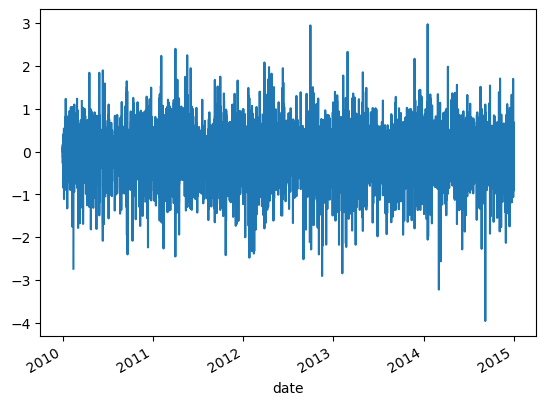

In [72]:
df1.pollu_log_diff.dropna().plot()

# 2. Square Root Transformation

In [73]:
df1['pollu_sqrt']= np.sqrt(df1['pollution'])
df1['pollu_sqrt_diff'] = df1['pollu_sqrt'] - df1['pollu_sqrt'].shift(24)
sqrt_diff = df1['pollu_sqrt_diff'].dropna()

In [74]:
test_stationarity(sqrt_diff.dropna())

Results of Dickey-Fuller Test:
Test Statistic                   -31.586476
p-value                            0.000000
#Lags Used                        55.000000
Number of Observations Used    43720.000000
Critical Value (1%)               -3.430500
Critical Value (5%)               -2.861606
Critical Value (10%)              -2.566805
dtype: float64 

Reject the null hypothesis
Data has no unit root and is stationary


<AxesSubplot:xlabel='date'>

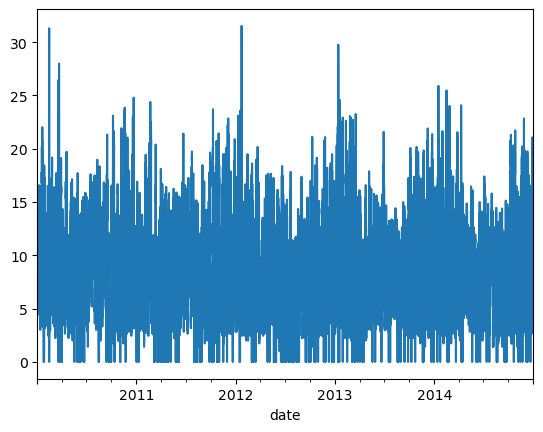

In [75]:
df1.pollu_sqrt.dropna().plot()

# Method 3 Rolling Window

In [76]:
df_sam.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollu_indicators,Year,Month,Day,WeekOfYear,Hours
date,,,,,,,,,,,,,,
2010-01-02 00:00:00,129,-16,-4,1020,2,1,0,0,moderate,2010,1,2,53,0
2010-01-02 01:00:00,148,-15,-4,1020,2,2,0,0,moderate,2010,1,2,53,1
2010-01-02 02:00:00,159,-11,-5,1021,2,3,0,0,moderate,2010,1,2,53,2
2010-01-02 03:00:00,181,-7,-5,1022,2,5,1,0,moderate,2010,1,2,53,3
2010-01-02 04:00:00,138,-7,-5,1022,2,6,2,0,moderate,2010,1,2,53,4


In [77]:
df = df_sam.copy()

In [78]:

def rolling_window(data):
#eterming rolling statistics
    roll_mean = data.rolling(window=4).mean()
    roll_std = data.rolling(window=4).std()

    mean = plt.plot(roll_mean, color='pink', label='Rolling Mean')
    std = plt.plot(roll_std, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    return roll_mean

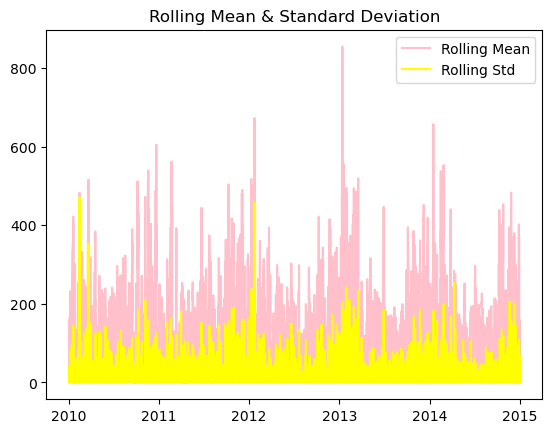

date
2010-01-02 00:00:00       NaN
2010-01-02 01:00:00       NaN
2010-01-02 02:00:00       NaN
2010-01-02 03:00:00    154.25
2010-01-02 04:00:00    156.50
                        ...  
2014-12-31 19:00:00      8.75
2014-12-31 20:00:00      9.25
2014-12-31 21:00:00      9.50
2014-12-31 22:00:00      9.00
2014-12-31 23:00:00     10.00
Name: pollution, Length: 43800, dtype: float64

In [79]:
rolling_window(df['pollution'])

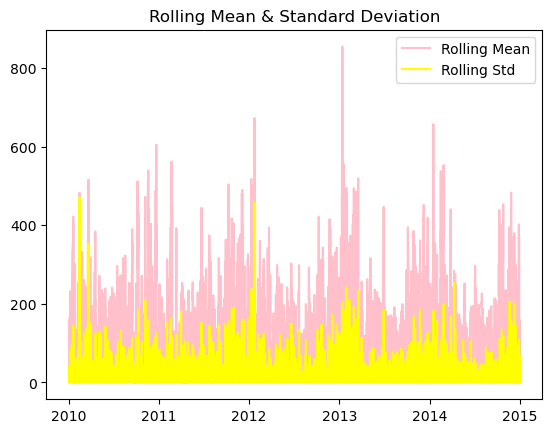

Results of Dickey-Fuller Test:
Test Statistic                   -20.174584
p-value                            0.000000
#Lags Used                        55.000000
Number of Observations Used    43741.000000
Critical Value (1%)               -3.430500
Critical Value (5%)               -2.861606
Critical Value (10%)              -2.566805
dtype: float64 

Reject the null hypothesis
Data has no unit root and is stationary


In [80]:
test_stationarity(rolling_window(df['pollution']).dropna())

# Method 4 Resampling Technique

# 1. Taking Resample of Frequency ''1Month''

In [81]:
df2= df_sam.copy()

In [82]:
df = df_sam.copy()

In [83]:
def resampling_tech(data):
    decomposition = seasonal_decompose(df[data], model="additive")

# remove the seasonal component from the time series data
    seasonal_com = decomposition.seasonal
    seasonal_removed = df[data] - seasonal_com

# plot the original time series data, seasonal component, and seasonality-removed data
    plot = decomposition.plot()
    
    # detrend the time series data using first-order differencing
    detrended = seasonal_removed.dropna()

# remove the trend component from the time series data
    trend_component = detrended.cumsum()
    detrended_seasonal_removed =seasonal_removed - trend_component
    final_plot = detrended_seasonal_removed.plot()
    return detrended_seasonal_removed 
    

In [84]:
def stationary_check(df):
    for i in df.columns:
        decomposition = seasonal_decompose(df[i], model="additive")

# remove the seasonal component from the time series data
        seasonal_com = decomposition.seasonal
        seasonal_removed = df[i]- seasonal_com    
    # detrend the time series data using first-order differencing
        detrended = seasonal_removed.dropna()

# remove the trend component from the time series data
        trend_component = detrended.cumsum()
        detrended_seasonal_removed =seasonal_removed - trend_component
     #Perform Dickey-Fuller test:
        dftest = adfuller(detrended_seasonal_removed, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
    
            if dfoutput[2] <= 0.05:
                print('The variable', i )
                print("Data has no unit root and is stationary")
                break

In [85]:
df = df.resample('1M').mean()

In [86]:
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,Year,Month,Day,WeekOfYear,Hours
date,,,,,,,,,,,,,
2010-01-31,82.026389,-16.955556,-6.143056,1028.373611,1.252778,41.570833,0.495833,0.000000,2010.0,1.0,16.5,5.866667,11.5
2010-02-28,97.089286,-13.156250,-1.922619,1023.776786,1.601190,12.880952,0.132440,0.000000,2010.0,2.0,14.5,6.500000,11.5
2010-03-31,89.673387,-7.955645,3.293011,1021.811828,1.668011,22.711022,0.239247,0.205645,2010.0,3.0,16.0,10.741935,11.5
2010-04-30,79.806944,-3.330556,10.806944,1017.169444,1.502778,57.741667,0.000000,0.252778,2010.0,4.0,15.5,15.066667,11.5
2010-05-31,86.081989,7.651882,20.831989,1007.896505,1.713710,20.842742,0.000000,0.534946,2010.0,5.0,16.0,19.419355,11.5


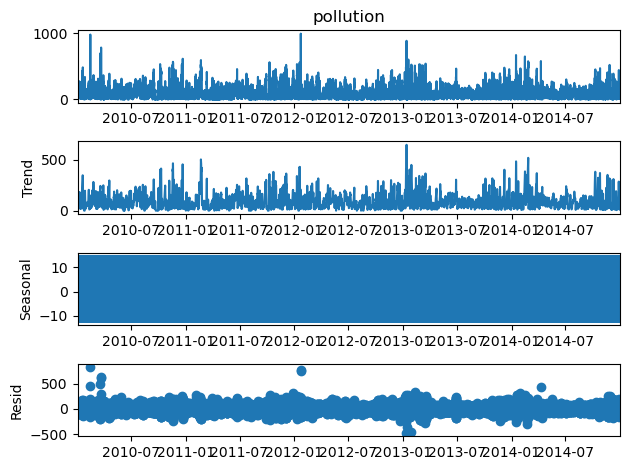

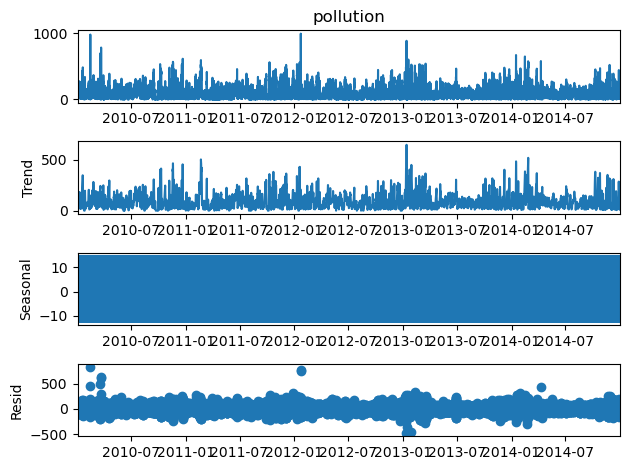

In [87]:
decomposition = seasonal_decompose(df2['pollution'], model="additive")

# remove the seasonal component from the time series data
seasonal_com = decomposition.seasonal
seasonal_removed = df2['pollution'] - seasonal_com

# plot the original time series data, seasonal component, and seasonality-removed data
decomposition.plot()

In [88]:
# detrend the time series data using first-order differencing
detrended = seasonal_removed.dropna()

# remove the trend component from the time series data
trend_component = detrended.cumsum()
detrended_seasonal_removed =seasonal_removed - trend_component


In [89]:
detrended_seasonal_removed.head()

date
2010-01-02 00:00:00      0.000000
2010-01-02 01:00:00   -115.238129
2010-01-02 02:00:00   -248.566764
2010-01-02 03:00:00   -396.490086
2010-01-02 04:00:00   -568.240665
dtype: float64

In [90]:
# Before trend and seasonality removal data
df2['pollution'].head()

date
2010-01-02 00:00:00    129
2010-01-02 01:00:00    148
2010-01-02 02:00:00    159
2010-01-02 03:00:00    181
2010-01-02 04:00:00    138
Name: pollution, dtype: int32

In [91]:
stationary_check(df)

The variable pollution
Data has no unit root and is stationary
The variable dew
Data has no unit root and is stationary
The variable press
Data has no unit root and is stationary
The variable wnd_dir
Data has no unit root and is stationary
The variable Day
Data has no unit root and is stationary


# Now it Attends Stationarity in the month-wise Frequency.

# Now lets try with week wise data

In [92]:
def stationary_check(df):
    for i in df.columns:
        decomposition = seasonal_decompose(df[i], model="additive")

# remove the seasonal component from the time series data
        seasonal_com = decomposition.seasonal
        seasonal_removed = df[i]- seasonal_com    
    # detrend the time series data using first-order differencing
        detrended = seasonal_removed.dropna()

# remove the trend component from the time series data
        trend_component = detrended.cumsum()
        detrended_seasonal_removed =seasonal_removed - trend_component
     #Perform Dickey-Fuller test:
        dftest = adfuller(detrended_seasonal_removed, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
            #print (dfoutput,'\n')
    
            if dfoutput[2] <= 0.05:
                print('The variable', i )
                print("Data has no unit root and is stationary")
                print
                break

In [93]:
df = df_sam.copy()

In [94]:
df = df.resample('1W').mean()
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,Year,Month,Day,WeekOfYear,Hours
date,,,,,,,,,,,,,
2010-01-03,112.395833,-9.312500,-6.833333,1023.770833,1.958333,47.312500,7.4375,0.0,2010.0,1.0,2.5,53.0,11.5
2010-01-10,74.452381,-19.976190,-11.511905,1031.470238,1.047619,32.250000,0.0000,0.0,2010.0,1.0,7.0,1.0,11.5
2010-01-17,86.708333,-18.083333,-9.047619,1031.345238,1.345238,42.875000,0.0000,0.0,2010.0,1.0,14.0,2.0,11.5
2010-01-24,108.452381,-14.202381,-3.119048,1028.255952,1.208333,38.279762,0.0000,0.0,2010.0,1.0,21.0,3.0,11.5
2010-01-31,49.815476,-17.744048,-0.696429,1023.738095,1.208333,51.238095,0.0000,0.0,2010.0,1.0,28.0,4.0,11.5


date
2010-01-03        0.000000
2010-01-10     -134.801995
2010-01-17     -232.971078
2010-01-24     -291.406029
2010-01-31     -360.183413
                  ...     
2014-12-07   -24253.818802
2014-12-14   -24285.968339
2014-12-21   -24369.802128
2014-12-28   -24439.568452
2015-01-04   -24582.623424
Freq: W-SUN, Length: 262, dtype: float64

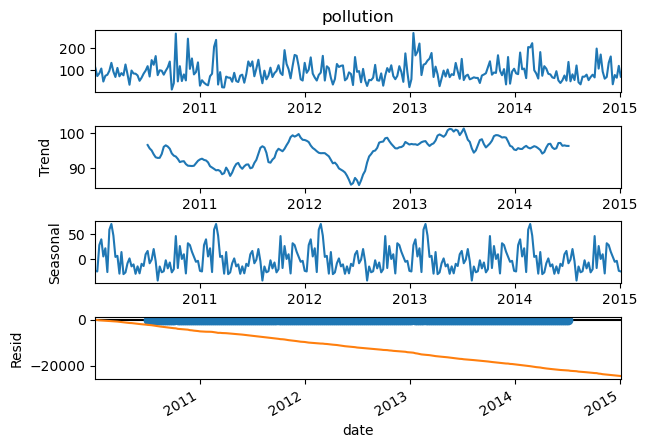

In [95]:
resampling_tech('pollution')

Results of Dickey-Fuller Test:
Test Statistic                   0.627762
p-value                          0.988280
#Lags Used                       0.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64 

Fail to reject the null hypothesis
Data has a unit root and is non-stationary


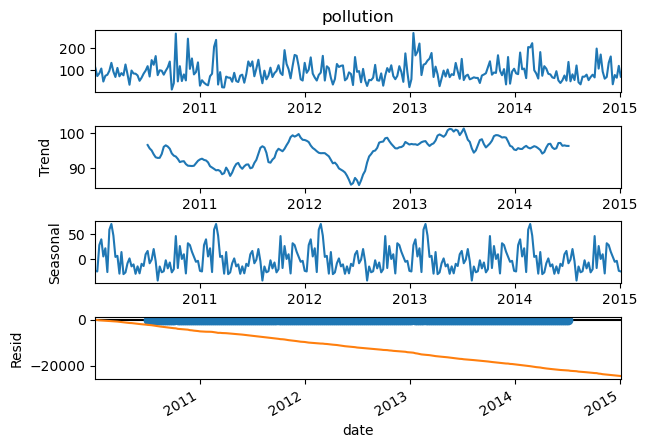

In [96]:
test_stationarity(resampling_tech('pollution'))

In [97]:
stationary_check(df)

The variable pollution
Data has no unit root and is stationary
The variable wnd_dir
Data has no unit root and is stationary
The variable rain
Data has no unit root and is stationary
The variable WeekOfYear
Data has no unit root and is stationary


# Weekly wise it is stationary

``IMPORTANT KEY POINTS``

        ``PROBLEMS ``
    
    
                        1. As per the Central pollution Control Board our data has a value above satisfactory level.
    
                        2. In  ``2012`` is the most polluted year among all. Here central board level of high is only upto 500 but here above the estimation so considered this as a most polluted year.
        
                        3. Among them january month had a lot. In this month many important days including new year celebration for world wide
         and republic day celebration for India level and ``Pongal`` festival for State level.
            
                        4. When we see the month first 4 and last 3 only had more pollution level. Let us consider ``December``month we are celebrating 
                ``Christmas`` which was celebrated by worldwide.
                        
                        5.  From this groupby In the year ``2012`` ``January`` month 23 rd is a Monday.  Monday all of them returning school, offices, etc.. So in terms of days Monday had most  pollution level.
        
                      6. The second highest level of pollution in the year ``2010`` ''Febrary`` month 14th is the 2nd highest that is ``Valentinesday`` which was celebrated by whole world.
            
                      7. The Third highest level of pollution in the year ``2013`` `` January`` month 12th that is ``saturday``.
                
                
                
                
     ``Effects`` 
    
    
                    1. Cardiovascular Diseases,
                       Cancer.
                       Neurological Disorders.
                       Gastrointestinal Disorders.
                       Kidney Diseases.
                       Liver Diseases.
                       Skin Diseases.
                       Asthma.                  
        These are the some of the major diseases caused by air pollution.  
        
        
        
    ``Solutions``
    
    
               1. Raising awareness: Raising awareness about the health impacts of air pollution and encouraging individuals to take action can help build public support for policies and initiatives to reduce air pollution.
    
               2. The above mentioned days are more polluted days and months. Taking consideration into that days and take preventive measures for future days
        
               3. Planting trees: Trees absorb carbon dioxide and other pollutants from the air, making them an effective natural solution to air pollution. Planting more trees in urban areas can also help reduce the urban heat island effect.
               
               4. Improving indoor air quality: Indoor air pollution can also be a problem, especially in homes with poor ventilation. Improving indoor air quality through better ventilation and air filtration systems can help reduce exposure to pollutants.

                     